# Men: Age Group & Degree Level Error Analysis

This notebook focuses specifically on **male demographic groups** and analyzes prediction errors across:
- Age groups (18-25, 26-35, 36-45, 46-55, 56+)
- Education/degree levels (HS-grad, Some-college, Bachelors, Masters, Doctorate, etc.)
- Marital status combinations

**Goal:** Identify which specific groups of men (e.g., "46-55 year old married man with a Bachelor's degree") have the highest prediction error rates.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 120)

print("Setup complete!")

Setup complete!


## 2. Load Model and Data

In [2]:
# Load model and preprocessing objects
print("Loading model and preprocessing objects...")
model = joblib.load('../backend/model.pkl')
scaler = joblib.load('../backend/scaler.pkl')
label_encoder = joblib.load('../backend/label_encoder.pkl')
feature_columns = joblib.load('../backend/feature_columns.pkl')

print(f"Model type: {type(model).__name__}")
print(f"Number of features: {len(feature_columns)}")

# Load data
df = pd.read_csv('../data/train.csv')
test_size = int(len(df) * 0.2)
test_df = df.tail(test_size).copy()

print(f"\nTest set size: {len(test_df):,}")
print("Model and data loaded successfully!")

Loading model and preprocessing objects...
Model type: CatBoostClassifier
Number of features: 97

Test set size: 8,791
Model and data loaded successfully!


## 3. Preprocess and Make Predictions

In [3]:
# Separate features and target
y_test = test_df['income_>50K'].values
X_test = test_df.drop(columns=['income_>50K', 'fnlwgt']).copy()

# Preprocess
X_test['gender'] = label_encoder.transform(X_test['gender'])
X_test = pd.get_dummies(X_test, columns=[
    'workclass', 'education', 'marital-status',
    'occupation', 'race', 'relationship', 'native-country'
], drop_first=True)

num_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X_test[num_cols] = scaler.transform(X_test[num_cols])

for col in feature_columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[feature_columns]

# Make predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.46).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy*100:.2f}%")
print(f"Overall Error Rate: {(1-accuracy)*100:.2f}%")

Overall Accuracy: 87.57%
Overall Error Rate: 12.43%


## 4. Create Analysis DataFrame - MALES ONLY

In [4]:
# Create analysis dataframe
test_df_analysis = test_df.copy()
test_df_analysis['predicted'] = y_pred
test_df_analysis['actual'] = y_test
test_df_analysis['probability'] = y_pred_proba
test_df_analysis['correct'] = (y_pred == y_test)

# Add age groups
test_df_analysis['age_group'] = pd.cut(test_df_analysis['age'],
                                        bins=[0, 25, 35, 45, 55, 100],
                                        labels=['18-25', '26-35', '36-45', '46-55', '56+'])

# Filter for MALES ONLY
men_df = test_df_analysis[test_df_analysis['gender'] == 'Male'].copy()

print(f"Total male records: {len(men_df):,}")
print(f"Correct predictions (males): {men_df['correct'].sum():,}")
print(f"Incorrect predictions (males): {(~men_df['correct']).sum():,}")
print(f"\nMale error rate: {(1 - men_df['correct'].mean())*100:.2f}%")

print(f"\nAge group distribution:")
print(men_df['age_group'].value_counts().sort_index())

men_df.head()

Total male records: 5,875
Correct predictions (males): 4,935
Incorrect predictions (males): 940

Male error rate: 16.00%

Age group distribution:
age_group
18-25     934
26-35    1593
36-45    1554
46-55    1050
56+       744
Name: count, dtype: int64


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K,predicted,actual,probability,correct,age_group
35167,41,Self-emp-not-inc,83411,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1,0,1,0.295384,False,36-45
35168,44,Private,230478,Assoc-acdm,12,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,60,United-States,1,0,1,0.283515,False,36-45
35170,23,Private,37514,Some-college,10,Never-married,Sales,Not-in-family,White,Male,0,0,55,United-States,0,0,0,0.013538,True,18-25
35172,24,Private,421474,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,0,0,0,0.240445,True,18-25
35173,44,Private,96321,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,1,1,1,0.509304,True,36-45


## 5. Men: Error Rate by Age Group

ERROR RATE FOR MEN BY AGE GROUP

Error Rate by Age Group:
           error_rate_%  count
age_group                     
18-25          1.605996    934
26-35         14.563716   1593
36-45         19.755470   1554
46-55         23.619048   1050
56+           18.548387    744


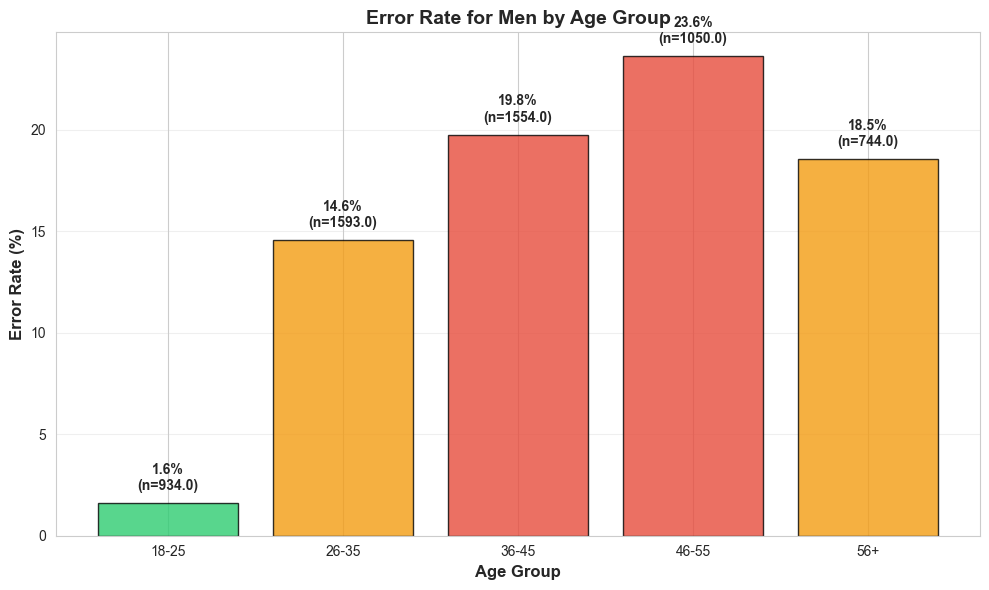

In [5]:
print("ERROR RATE FOR MEN BY AGE GROUP")
print("=" * 70)

men_age_stats = men_df.groupby('age_group', observed=True).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

print("\nError Rate by Age Group:")
print(men_age_stats)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#e74c3c', '#f39c12']
bars = ax.bar(range(len(men_age_stats)), men_age_stats['error_rate_%'],
              color=colors, edgecolor='black', alpha=0.8)
ax.set_xticks(range(len(men_age_stats)))
ax.set_xticklabels(men_age_stats.index)
ax.set_xlabel('Age Group', fontweight='bold', fontsize=12)
ax.set_ylabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax.set_title('Error Rate for Men by Age Group', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (idx, row) in enumerate(men_age_stats.iterrows()):
    ax.text(i, row['error_rate_%'] + 0.5,
            f"{row['error_rate_%']:.1f}%\n(n={row['count']})",
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Men: Error Rate by Education Level

ERROR RATE FOR MEN BY EDUCATION LEVEL

Error Rate by Education Level (min 30 samples):
              error_rate_%  count
education                        
Assoc-voc        21.250000    240
Bachelors        19.430815   1019
Some-college     19.269103   1204
Masters          18.649518    311
Assoc-acdm       17.714286    175
HS-grad          15.272727   1925
Doctorate        10.465116     86
Prof-school       9.836066    122
12th              9.677419     62
7th-8th           9.558824    136
10th              9.271523    151
11th              7.727273    220
5th-6th           3.389831     59
9th               2.752294    109
1st-4th           0.000000     41


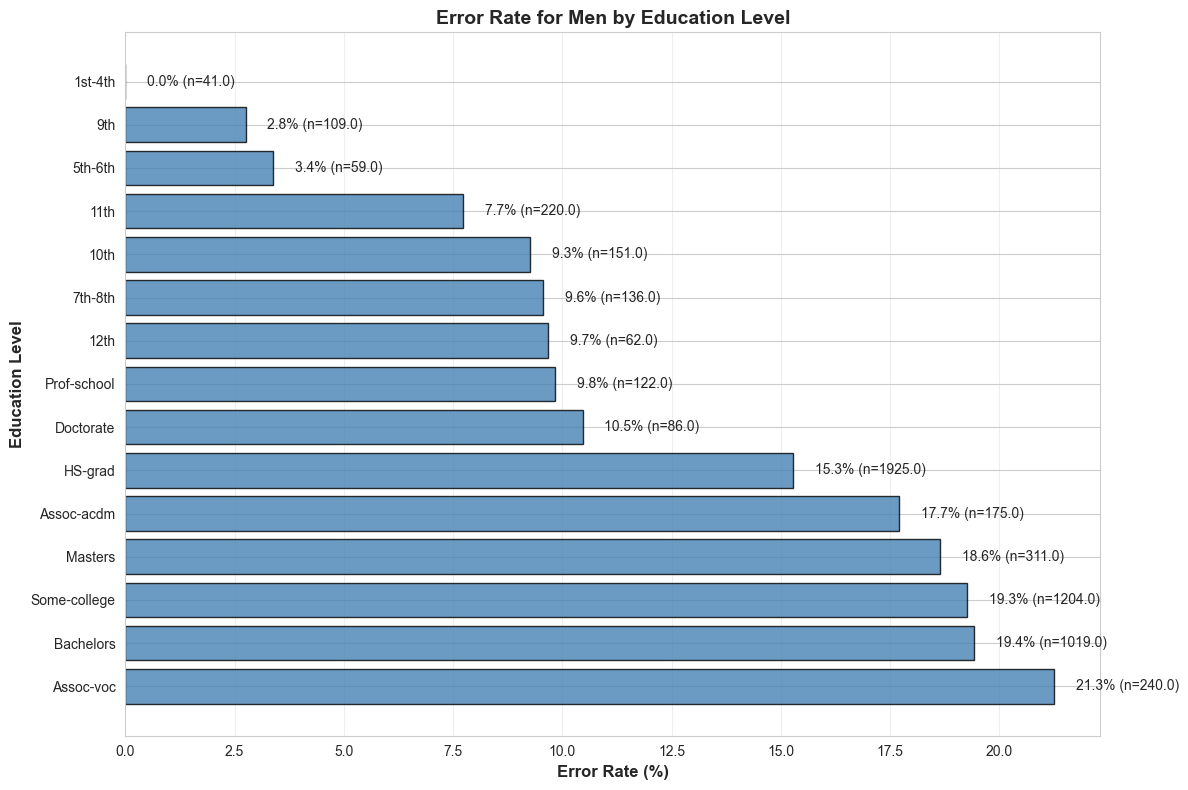

In [6]:
print("ERROR RATE FOR MEN BY EDUCATION LEVEL")
print("=" * 70)

men_education_stats = men_df.groupby('education').agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

# Filter for education levels with at least 30 samples
men_education_stats_filtered = men_education_stats[men_education_stats['count'] >= 30]
men_education_stats_sorted = men_education_stats_filtered.sort_values('error_rate_%', ascending=False)

print("\nError Rate by Education Level (min 30 samples):")
print(men_education_stats_sorted)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
bars = ax.barh(range(len(men_education_stats_sorted)), men_education_stats_sorted['error_rate_%'],
               color='steelblue', edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(men_education_stats_sorted)))
ax.set_yticklabels(men_education_stats_sorted.index)
ax.set_xlabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Education Level', fontweight='bold', fontsize=12)
ax.set_title('Error Rate for Men by Education Level', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(men_education_stats_sorted.iterrows()):
    ax.text(row['error_rate_%'] + 0.5, i,
            f"{row['error_rate_%']:.1f}% (n={row['count']})",
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Men: Age Group + Education Combinations

In [7]:
print("ERROR RATE FOR MEN: AGE GROUP + EDUCATION COMBINATIONS")
print("=" * 80)

# Calculate error rates for age + education combinations
men_age_edu_combo = men_df.groupby(['age_group', 'education'], observed=True).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

men_age_edu_combo_reset = men_age_edu_combo.reset_index()

# Filter for combinations with at least 20 samples
men_age_edu_filtered = men_age_edu_combo_reset[men_age_edu_combo_reset['count'] >= 20]
men_age_edu_sorted = men_age_edu_filtered.sort_values('error_rate_%', ascending=False)

print("\nTop 20 Most Error-Prone Age+Education Combinations for Men (min 20 samples):")
print(men_age_edu_sorted.head(20).to_string(index=False))

# Focus on specific degree levels
print("\n\n" + "=" * 80)
print("BREAKDOWN BY SPECIFIC DEGREE LEVELS")
print("=" * 80)

degree_levels = ['HS-grad', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']

for degree in degree_levels:
    degree_data = men_age_edu_combo_reset[
        (men_age_edu_combo_reset['education'] == degree) &
        (men_age_edu_combo_reset['count'] >= 10)
    ].sort_values('age_group')
    
    if len(degree_data) > 0:
        print(f"\n{degree.upper()}:")
        print(degree_data[['age_group', 'error_rate_%', 'count']].to_string(index=False))

ERROR RATE FOR MEN: AGE GROUP + EDUCATION COMBINATIONS

Top 20 Most Error-Prone Age+Education Combinations for Men (min 20 samples):
age_group    education  error_rate_%  count
    46-55         11th     31.818182     22
    46-55 Some-college     30.813953    172
    46-55    Assoc-voc     30.303030     33
    36-45 Some-college     29.449838    309
      56+    Bachelors     27.777778    108
    46-55      HS-grad     27.647059    340
    36-45   Assoc-acdm     27.118644     59
    46-55   Assoc-acdm     24.000000     25
    46-55    Bachelors     23.369565    184
    26-35      Masters     23.333333     60
      56+ Some-college     22.222222    108
    46-55      Masters     21.111111     90
    36-45    Assoc-voc     20.731707     82
    26-35    Bachelors     20.588235    306
      56+      HS-grad     20.331950    241
    26-35    Assoc-voc     19.047619     84
    36-45    Bachelors     19.003115    321
    36-45      HS-grad     18.354430    474
    26-35 Some-college     18.3

## 8. Visualization: Men Age + Education Heatmap

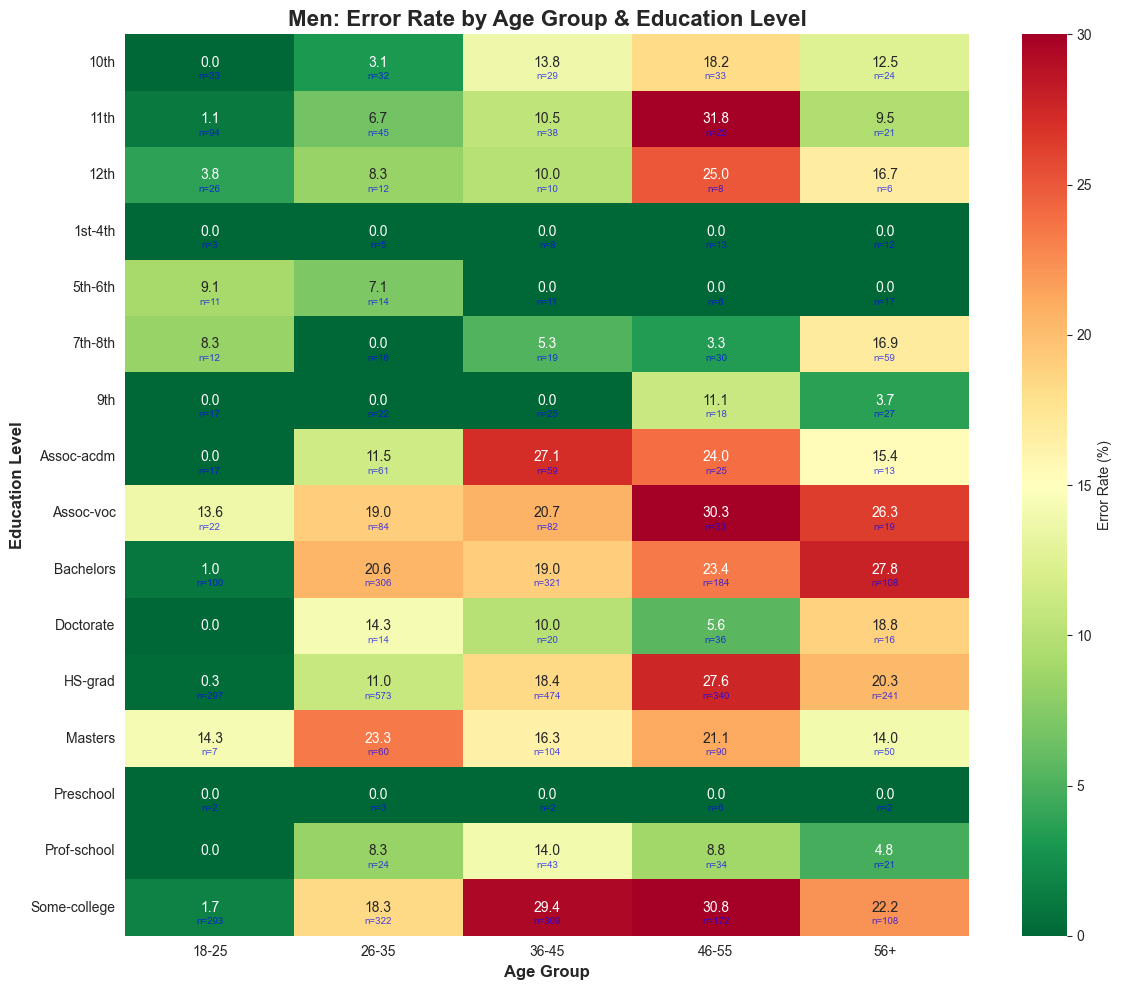

In [8]:
# Create pivot table for heatmap
men_age_edu_pivot = men_age_edu_combo.reset_index().pivot(
    index='education', columns='age_group', values='error_rate_%'
)

men_age_edu_count_pivot = men_age_edu_combo.reset_index().pivot(
    index='education', columns='age_group', values='count'
)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Create heatmap
sns.heatmap(men_age_edu_pivot.fillna(0), annot=True, fmt='.1f', cmap='RdYlGn_r',
            ax=ax, cbar_kws={'label': 'Error Rate (%)'}, vmin=0, vmax=30)

ax.set_title('Men: Error Rate by Age Group & Education Level', fontsize=16, fontweight='bold')
ax.set_xlabel('Age Group', fontweight='bold', fontsize=12)
ax.set_ylabel('Education Level', fontweight='bold', fontsize=12)

# Add sample counts
for i, education in enumerate(men_age_edu_count_pivot.index):
    for j, age_group in enumerate(men_age_edu_count_pivot.columns):
        count = men_age_edu_count_pivot.loc[education, age_group]
        if pd.notna(count) and count > 0:
            ax.text(j + 0.5, i + 0.75, f'n={int(count)}',
                   ha='center', va='center', fontsize=7, color='blue', alpha=0.7)

plt.tight_layout()
plt.show()

## 9. Men: Age + Education + Marital Status (3-Feature Analysis)

In [9]:
print("ERROR RATE FOR MEN: AGE + EDUCATION + MARITAL STATUS")
print("=" * 80)

# Calculate error rates for 3-feature combinations
men_three_combo = men_df.groupby(['age_group', 'education', 'marital-status'], observed=True).agg({
    'correct': lambda x: (1 - x.mean()) * 100,
    'age': 'count'
}).rename(columns={'correct': 'error_rate_%', 'age': 'count'})

men_three_combo_reset = men_three_combo.reset_index()

# Filter for combinations with at least 15 samples
men_three_filtered = men_three_combo_reset[men_three_combo_reset['count'] >= 15]
men_three_sorted = men_three_filtered.sort_values('error_rate_%', ascending=False)

print("\nTop 25 Most Error-Prone Age+Education+Marital Combinations for Men:")
print(men_three_sorted.head(25).to_string(index=False))

ERROR RATE FOR MEN: AGE + EDUCATION + MARITAL STATUS

Top 25 Most Error-Prone Age+Education+Marital Combinations for Men:
age_group    education     marital-status  error_rate_%  count
    46-55         11th Married-civ-spouse     35.294118     17
    36-45 Some-college Married-civ-spouse     34.821429    224
    46-55   Assoc-acdm Married-civ-spouse     33.333333     18
    46-55      HS-grad Married-civ-spouse     33.208955    268
    46-55 Some-college Married-civ-spouse     33.093525    139
    26-35      Masters Married-civ-spouse     32.432432     37
    26-35 Some-college Married-civ-spouse     31.428571    175
    26-35    Assoc-voc Married-civ-spouse     31.250000     48
    46-55    Assoc-voc Married-civ-spouse     30.000000     30
      56+    Bachelors Married-civ-spouse     29.032258     93
    46-55 Some-college           Divorced     28.571429     21
    36-45    Assoc-voc Married-civ-spouse     28.333333     60
    26-35    Bachelors Married-civ-spouse     26.256983    

## 10. Deep Dive: Married Men by Age & Degree

In [10]:
print("=" * 80)
print("MARRIED MEN: ERROR RATE BY AGE GROUP & DEGREE LEVEL")
print("=" * 80)

# Filter for married men
married_men = men_three_combo_reset[
    men_three_combo_reset['marital-status'] == 'Married-civ-spouse'
]

# Group by degree level
degree_levels = ['HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Doctorate']

for degree in degree_levels:
    degree_data = married_men[
        (married_men['education'] == degree) &
        (married_men['count'] >= 10)
    ].sort_values('age_group')
    
    if len(degree_data) > 0:
        print(f"\n{'='*80}")
        print(f"MARRIED MEN WITH {degree.upper()}")
        print(f"{'='*80}")
        print(degree_data[['age_group', 'error_rate_%', 'count']].to_string(index=False))
        
        # Calculate average
        avg_error = degree_data['error_rate_%'].mean()
        total_count = degree_data['count'].sum()
        print(f"\nAverage error rate: {avg_error:.2f}%")
        print(f"Total samples: {total_count}")

MARRIED MEN: ERROR RATE BY AGE GROUP & DEGREE LEVEL

MARRIED MEN WITH HS-GRAD
age_group  error_rate_%  count
    18-25      2.040816     49
    26-35     16.034985    343
    36-45     25.074627    335
    46-55     33.208955    268
      56+     23.880597    201

Average error rate: 20.05%
Total samples: 1196

MARRIED MEN WITH SOME-COLLEGE
age_group  error_rate_%  count
    18-25     10.714286     28
    26-35     31.428571    175
    36-45     34.821429    224
    46-55     33.093525    139
      56+     25.287356     87

Average error rate: 27.07%
Total samples: 653

MARRIED MEN WITH ASSOC-VOC
age_group  error_rate_%  count
    26-35     31.250000     48
    36-45     28.333333     60
    46-55     30.000000     30
      56+     20.000000     15

Average error rate: 27.40%
Total samples: 153

MARRIED MEN WITH ASSOC-ACDM
age_group  error_rate_%  count
    26-35     19.354839     31
    36-45     25.000000     40
    46-55     33.333333     18
      56+     18.181818     11

Average e

## 11. Visualization: Married Men - Degree Comparison Across Age Groups

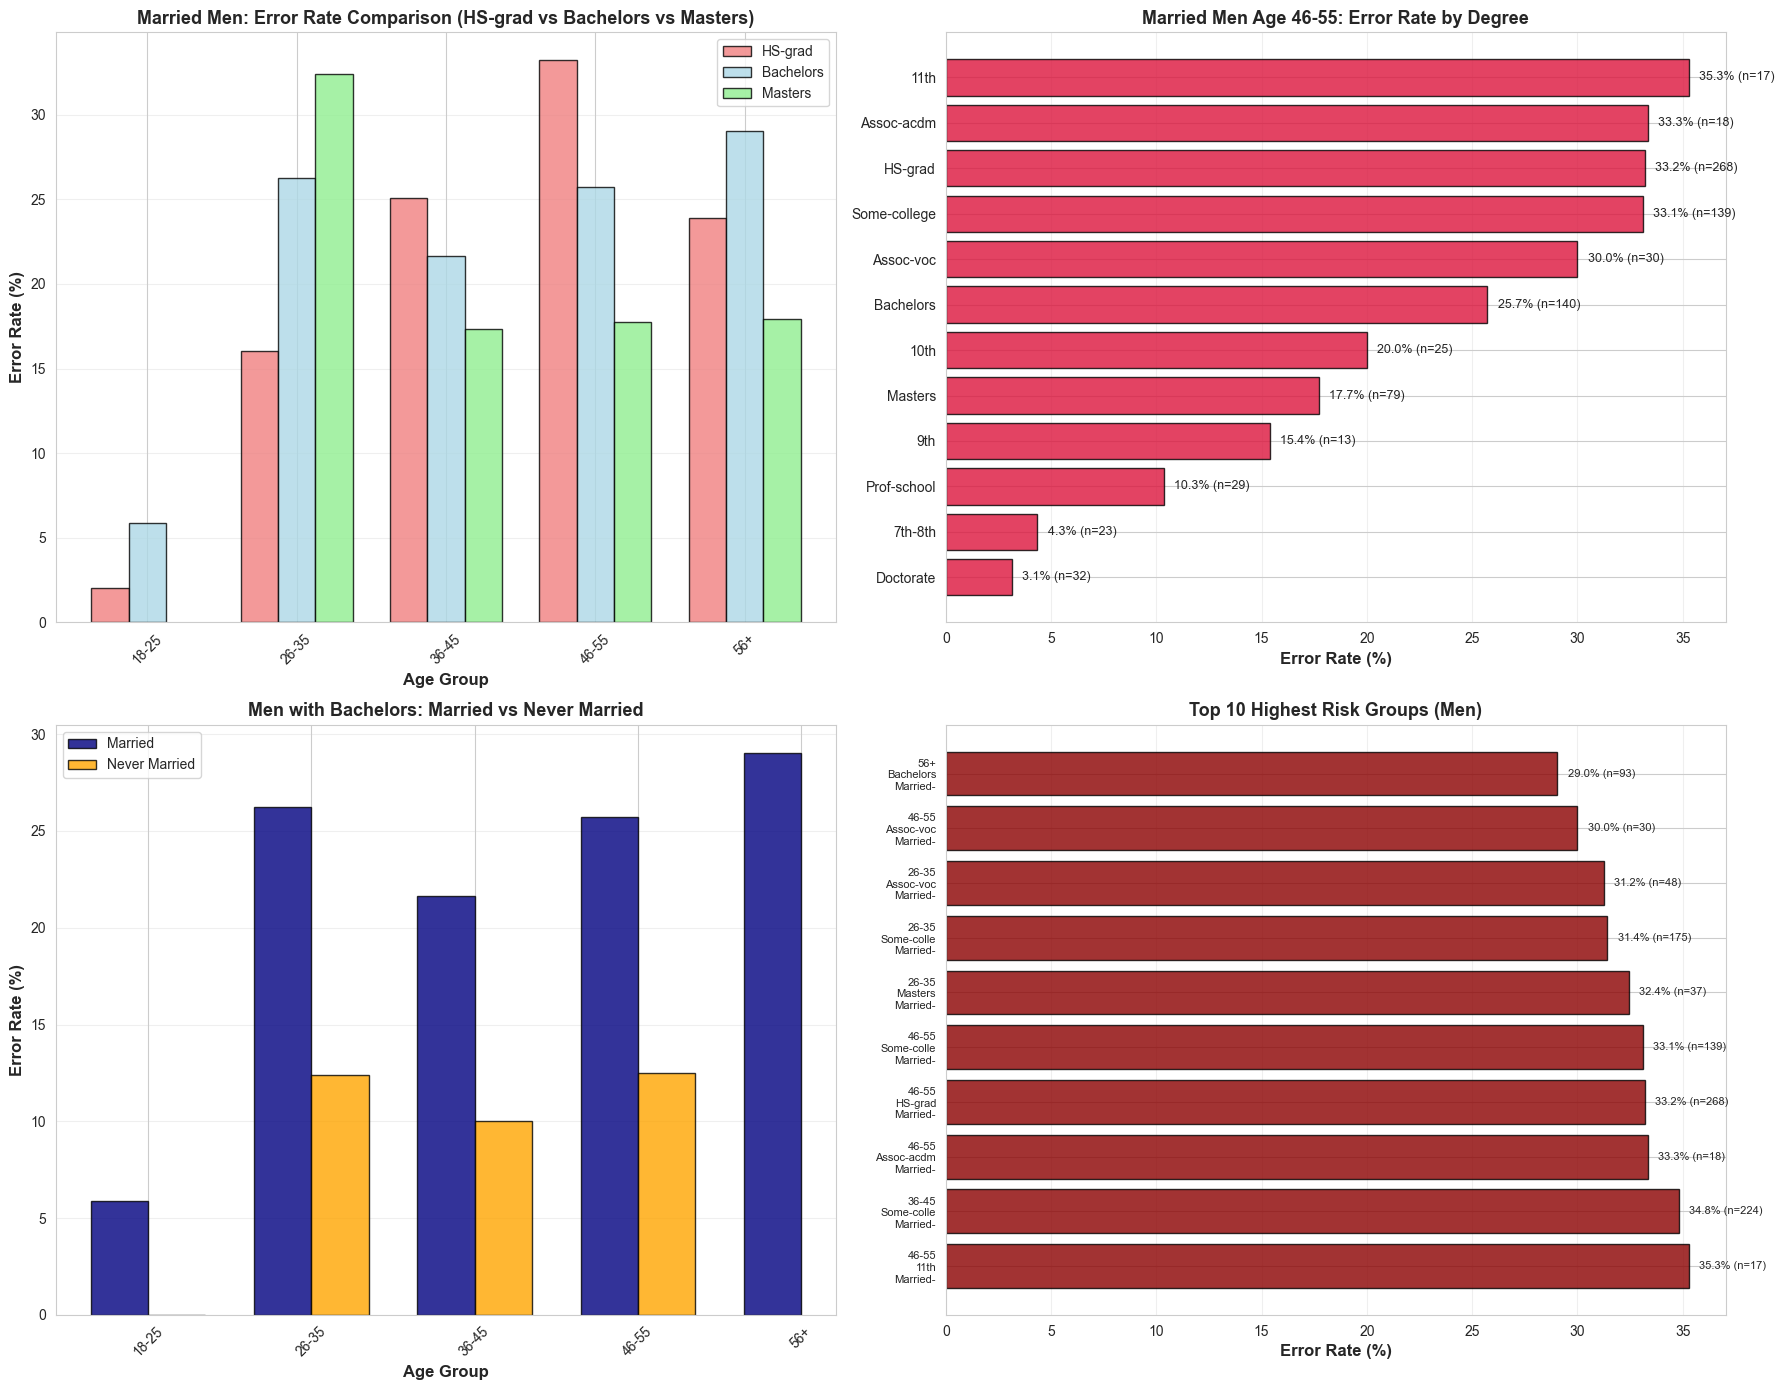

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Married men: HS-grad, Bachelors, Masters comparison
ax1 = axes[0, 0]
education_levels = ['HS-grad', 'Bachelors', 'Masters']
age_groups_order = ['18-25', '26-35', '36-45', '46-55', '56+']
colors = ['lightcoral', 'lightblue', 'lightgreen']

x = np.arange(len(age_groups_order))
width = 0.25

for i, edu in enumerate(education_levels):
    married_by_age_edu = married_men[
        (married_men['education'] == edu) &
        (married_men['count'] >= 5)
    ].set_index('age_group')['error_rate_%'].reindex(age_groups_order)
    
    offset = (i - 1) * width
    ax1.bar(x + offset, married_by_age_edu.values, width,
            label=edu, color=colors[i], edgecolor='black', alpha=0.8)

ax1.set_xlabel('Age Group', fontweight='bold', fontsize=12)
ax1.set_ylabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax1.set_title('Married Men: Error Rate Comparison (HS-grad vs Bachelors vs Masters)',
              fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(age_groups_order, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Married men: All degrees for age 46-55 (highest risk age group)
ax2 = axes[0, 1]
age_46_55_married = married_men[
    (married_men['age_group'] == '46-55') &
    (married_men['count'] >= 10)
].sort_values('error_rate_%', ascending=True)

bars = ax2.barh(range(len(age_46_55_married)), age_46_55_married['error_rate_%'],
                color='crimson', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(age_46_55_married)))
ax2.set_yticklabels(age_46_55_married['education'])
ax2.set_xlabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax2.set_title('Married Men Age 46-55: Error Rate by Degree',
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for i, (idx, row) in enumerate(age_46_55_married.iterrows()):
    ax2.text(row['error_rate_%'] + 0.5, i,
             f"{row['error_rate_%']:.1f}% (n={row['count']})",
             va='center', fontsize=9)

# 3. Married vs Never-married men with Bachelors degree
ax3 = axes[1, 0]

married_bachelors = men_three_combo_reset[
    (men_three_combo_reset['marital-status'] == 'Married-civ-spouse') &
    (men_three_combo_reset['education'] == 'Bachelors') &
    (men_three_combo_reset['count'] >= 5)
].set_index('age_group')['error_rate_%'].reindex(age_groups_order)

never_married_bachelors = men_three_combo_reset[
    (men_three_combo_reset['marital-status'] == 'Never-married') &
    (men_three_combo_reset['education'] == 'Bachelors') &
    (men_three_combo_reset['count'] >= 5)
].set_index('age_group')['error_rate_%'].reindex(age_groups_order)

x = np.arange(len(age_groups_order))
width = 0.35

ax3.bar(x - width/2, married_bachelors.values, width,
        label='Married', color='navy', edgecolor='black', alpha=0.8)
ax3.bar(x + width/2, never_married_bachelors.values, width,
        label='Never Married', color='orange', edgecolor='black', alpha=0.8)

ax3.set_xlabel('Age Group', fontweight='bold', fontsize=12)
ax3.set_ylabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax3.set_title('Men with Bachelors: Married vs Never Married',
              fontsize=13, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(age_groups_order, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Highest risk combinations overall
ax4 = axes[1, 1]
top_10_risk = men_three_sorted.head(10).copy()
top_10_risk['label'] = (top_10_risk['age_group'].astype(str) + '\n' +
                        top_10_risk['education'].str[:10] + '\n' +
                        top_10_risk['marital-status'].str[:8])

bars = ax4.barh(range(len(top_10_risk)), top_10_risk['error_rate_%'],
                color='darkred', edgecolor='black', alpha=0.8)
ax4.set_yticks(range(len(top_10_risk)))
ax4.set_yticklabels(top_10_risk['label'], fontsize=8)
ax4.set_xlabel('Error Rate (%)', fontweight='bold', fontsize=12)
ax4.set_title('Top 10 Highest Risk Groups (Men)',
              fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

for i, (idx, row) in enumerate(top_10_risk.iterrows()):
    ax4.text(row['error_rate_%'] + 0.5, i,
             f"{row['error_rate_%']:.1f}% (n={row['count']})",
             va='center', fontsize=8)

plt.tight_layout()
plt.show()

## 12. Deep Dive: Divorced/Separated Men by Age & Degree

In [12]:
print("=" * 80)
print("DIVORCED/SEPARATED MEN: ERROR RATE BY AGE GROUP & DEGREE LEVEL")
print("=" * 80)

# Filter for divorced/separated men
divorced_separated_men = men_three_combo_reset[
    men_three_combo_reset['marital-status'].isin(['Divorced', 'Separated'])
]

# Filter for combinations with at least 5 samples
divorced_separated_filtered = divorced_separated_men[
    divorced_separated_men['count'] >= 5
].sort_values('error_rate_%', ascending=False)

print("\nTop 15 Error-Prone Groups (Divorced/Separated Men):")
print(divorced_separated_filtered.head(15).to_string(index=False))

# Breakdown by education level
print("\n\n" + "=" * 80)
print("BREAKDOWN BY DEGREE LEVEL (Divorced/Separated Men)")
print("=" * 80)

for degree in ['HS-grad', 'Some-college', 'Bachelors', 'Masters']:
    degree_data = divorced_separated_men[
        (divorced_separated_men['education'] == degree) &
        (divorced_separated_men['count'] >= 5)
    ].sort_values('age_group')
    
    if len(degree_data) > 0:
        print(f"\n{degree.upper()}:")
        print(degree_data[['age_group', 'marital-status', 'error_rate_%', 'count']].to_string(index=False))

DIVORCED/SEPARATED MEN: ERROR RATE BY AGE GROUP & DEGREE LEVEL

Top 15 Error-Prone Groups (Divorced/Separated Men):
age_group    education marital-status  error_rate_%  count
    46-55      Masters       Divorced     71.428571      7
    36-45 Some-college      Separated     33.333333      9
    46-55 Some-college       Divorced     28.571429     21
    36-45 Some-college       Divorced     25.000000     32
    26-35    Bachelors       Divorced     22.222222      9
    36-45   Assoc-acdm       Divorced     22.222222      9
    26-35   Assoc-acdm       Divorced     16.666667      6
    26-35         11th       Divorced     16.666667      6
    46-55    Bachelors       Divorced     13.636364     22
      56+ Some-college       Divorced     11.111111      9
    46-55      HS-grad       Divorced      9.090909     44
    36-45    Bachelors       Divorced      8.333333     24
      56+      HS-grad       Divorced      5.555556     18
    26-35      HS-grad      Separated      5.263158     19

## 13. Deep Dive: Never-Married Men by Age & Degree

In [13]:
print("=" * 80)
print("NEVER-MARRIED MEN: ERROR RATE BY AGE GROUP & DEGREE LEVEL")
print("=" * 80)

# Filter for never-married men
never_married_men = men_three_combo_reset[
    men_three_combo_reset['marital-status'] == 'Never-married'
]

# Group by degree level
for degree in ['HS-grad', 'Some-college', 'Bachelors', 'Masters']:
    degree_data = never_married_men[
        (never_married_men['education'] == degree) &
        (never_married_men['count'] >= 10)
    ].sort_values('age_group')
    
    if len(degree_data) > 0:
        print(f"\n{'='*80}")
        print(f"NEVER-MARRIED MEN WITH {degree.upper()}")
        print(f"{'='*80}")
        print(degree_data[['age_group', 'error_rate_%', 'count']].to_string(index=False))
        
        # Calculate average
        avg_error = degree_data['error_rate_%'].mean()
        total_count = degree_data['count'].sum()
        print(f"\nAverage error rate: {avg_error:.2f}%")
        print(f"Total samples: {total_count}")

NEVER-MARRIED MEN: ERROR RATE BY AGE GROUP & DEGREE LEVEL

NEVER-MARRIED MEN WITH HS-GRAD
age_group  error_rate_%  count
    18-25      0.000000    239
    26-35      2.439024    164
    36-45      1.562500     64
    46-55      6.250000     16

Average error rate: 2.56%
Total samples: 483

NEVER-MARRIED MEN WITH SOME-COLLEGE
age_group  error_rate_%  count
    18-25      0.766284    261
    26-35      2.912621    103
    36-45      4.651163     43

Average error rate: 2.78%
Total samples: 407

NEVER-MARRIED MEN WITH BACHELORS
age_group  error_rate_%  count
    18-25      0.000000     83
    26-35     12.389381    113
    36-45     10.000000     30
    46-55     12.500000     16

Average error rate: 8.72%
Total samples: 242

NEVER-MARRIED MEN WITH MASTERS
age_group  error_rate_%  count
    26-35      4.545455     22
    36-45     14.285714     14

Average error rate: 9.42%
Total samples: 36


## 14. Summary: Key Findings for Men

In [14]:
print("=" * 80)
print("COMPREHENSIVE SUMMARY: MEN - AGE & DEGREE ERROR ANALYSIS")
print("=" * 80)

# Overall male error rate
male_error_rate = (1 - men_df['correct'].mean()) * 100
print(f"\nOverall Male Error Rate: {male_error_rate:.2f}%")
print(f"Total Male Samples: {len(men_df):,}")

# Highest risk age group
highest_risk_age = men_age_stats['error_rate_%'].idxmax()
highest_risk_age_rate = men_age_stats.loc[highest_risk_age, 'error_rate_%']
print(f"\n1. HIGHEST RISK AGE GROUP:")
print(f"   Age Group: {highest_risk_age}")
print(f"   Error Rate: {highest_risk_age_rate:.2f}%")
print(f"   Sample Size: {men_age_stats.loc[highest_risk_age, 'count']}")

# Highest risk education level
highest_risk_edu = men_education_stats_sorted.iloc[0]
print(f"\n2. HIGHEST RISK EDUCATION LEVEL:")
print(f"   Education: {highest_risk_edu.name}")
print(f"   Error Rate: {highest_risk_edu['error_rate_%']:.2f}%")
print(f"   Sample Size: {highest_risk_edu['count']}")

# Top 5 age+education combinations
print(f"\n3. TOP 5 HIGHEST RISK AGE+EDUCATION COMBINATIONS:")
for i, (idx, row) in enumerate(men_age_edu_sorted.head(5).iterrows(), 1):
    print(f"   {i}. {row['age_group']} + {row['education']}")
    print(f"      Error Rate: {row['error_rate_%']:.2f}% (n={row['count']})")

# Top 5 age+education+marital combinations
print(f"\n4. TOP 5 HIGHEST RISK AGE+EDUCATION+MARITAL COMBINATIONS:")
for i, (idx, row) in enumerate(men_three_sorted.head(5).iterrows(), 1):
    print(f"   {i}. {row['age_group']} + {row['education']} + {row['marital-status']}")
    print(f"      Error Rate: {row['error_rate_%']:.2f}% (n={row['count']})")

# Married men insights
married_men_error = married_men['error_rate_%'].mean()
print(f"\n5. MARRIED MEN:")
print(f"   Average Error Rate: {married_men_error:.2f}%")
print(f"   Total Combinations: {len(married_men)}")

# Highest risk married men group
highest_married = married_men[married_men['count'] >= 15].sort_values('error_rate_%', ascending=False).iloc[0]
print(f"   Highest Risk Group: {highest_married['age_group']} + {highest_married['education']}")
print(f"   Error Rate: {highest_married['error_rate_%']:.2f}% (n={highest_married['count']})")

# Education level comparison for married men age 46-55
print(f"\n6. MARRIED MEN AGE 46-55 BY EDUCATION:")
married_46_55 = married_men[
    (married_men['age_group'] == '46-55') &
    (married_men['count'] >= 10)
].sort_values('error_rate_%', ascending=False)

for idx, row in married_46_55.iterrows():
    print(f"   {row['education']:20s}: {row['error_rate_%']:5.1f}% (n={row['count']})")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)

COMPREHENSIVE SUMMARY: MEN - AGE & DEGREE ERROR ANALYSIS

Overall Male Error Rate: 16.00%
Total Male Samples: 5,875

1. HIGHEST RISK AGE GROUP:
   Age Group: 46-55
   Error Rate: 23.62%
   Sample Size: 1050

2. HIGHEST RISK EDUCATION LEVEL:
   Education: Assoc-voc
   Error Rate: 21.25%
   Sample Size: 240.0

3. TOP 5 HIGHEST RISK AGE+EDUCATION COMBINATIONS:
   1. 46-55 + 11th
      Error Rate: 31.82% (n=22)
   2. 46-55 + Some-college
      Error Rate: 30.81% (n=172)
   3. 46-55 + Assoc-voc
      Error Rate: 30.30% (n=33)
   4. 36-45 + Some-college
      Error Rate: 29.45% (n=309)
   5. 56+ + Bachelors
      Error Rate: 27.78% (n=108)

4. TOP 5 HIGHEST RISK AGE+EDUCATION+MARITAL COMBINATIONS:
   1. 46-55 + 11th + Married-civ-spouse
      Error Rate: 35.29% (n=17)
   2. 36-45 + Some-college + Married-civ-spouse
      Error Rate: 34.82% (n=224)
   3. 46-55 + Assoc-acdm + Married-civ-spouse
      Error Rate: 33.33% (n=18)
   4. 46-55 + HS-grad + Married-civ-spouse
      Error Rate: 33.21% 